In [1]:
import gymnasium as gym
import numpy as np
import random
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
desc=["SFF", "FHF", "FGF"]

env = gym.make('FrozenLake-v1', desc=desc, map_name="5x5", is_slippery=False, render_mode = "human") 
observation, info = env.reset()

In [3]:
def calculate_percentage_change(old_q_table, new_q_table):
    """
    Calculate the percentage change in Q-values between two Q-tables.

    Parameters:
        old_q_table (numpy.ndarray): The old Q-table.
        new_q_table (numpy.ndarray): The new Q-table.

    Returns:
        float: The percentage change in Q-values.
    """
    q_diff = np.abs(new_q_table - old_q_table)
    avg_change = np.mean(q_diff)
    old_avg = np.mean(old_q_table)
    return (avg_change / old_avg) * 100

In [4]:
blacklistedActions = np.empty((env.observation_space.n), dtype=object)

for rowIndex, row in enumerate(desc):
    for columnIndex, typ in enumerate(row):
        blacklist = []
        if rowIndex == 0:
            blacklist.append(3)
        elif rowIndex == len(desc)-1:
            blacklist.append(1)
        if columnIndex == 0:
            blacklist.append(0)
        elif columnIndex == len(row)-1:
            blacklist.append(2)
        blacklistedActions[(3*rowIndex)+(columnIndex)] = blacklist

def is_valid_action(state, action):
    stateBlacklist = blacklistedActions[state]
    
    if action in stateBlacklist:
        return False
    else:
        return True

In [5]:
def runTrial():
    # Define parameters
    gamma = 0.9  # Discount factor
    alpha = 0.1  # Learning rate
    epsilon = 0.01  # Epsilon-greedy parameter

    # Initialize Q-values
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    Q = np.zeros((num_states, num_actions))

    stateI = 0
    for state in Q:
        for action in blacklistedActions[stateI]:
            Q[stateI][action] = -1
        stateI+=1

    statistics = pd.DataFrame({
        "Time": [],
        "Episode": [],
        "Q-Difference": [],
        "GotGift": [],
        "ActionCount": []
    })

    # Monte Carlo
    start_time = time.time()
    
    timeToConverge = 0

    actions = 0
    episode = 0
    loop = True
    while loop:
        state = env.reset()[0]
        done = False

        gotGift = False

        episode_states = []
        episode_actions = []
        episode_rewards = []


        states = []
        
        arr_copy = Q.copy()

        while not done:
            # Epsilon-greedy action selection

            if np.random.rand() < epsilon:
                actionLoop = True
                while actionLoop:
                    action = env.action_space.sample()  # Random action
                    if is_valid_action(state, action):
                        actionLoop = False
            else:
                actionLoop = True
                action = np.argmax(Q[state])  # Greedy action
                while actionLoop:
                    if is_valid_action(state, action):
                        actionLoop = False
                    else:
                        action = env.action_space.sample()  # Random action

            episode_states.append(state)
            episode_actions.append(action)

            states.append(state)
            # Take action and observe next state and reward
            step = env.step(action)
            actions+=1
            next_state = step[0]
            reward = step[1]
            done = step[2]

            if reward == 0 and done:
                reward = -1
            elif next_state == state:
                reward = -1
            elif reward == 1:
                gotGift = True
                print("Hit gift! At Episode: "+str(episode +1))
                print(Q)
                states.append(next_state)
                print("States: ")
                print(states)
                gotGift = True
                end_time = time.time()
                elapsed_time = end_time - start_time
                print("Elapsed time:", elapsed_time, "seconds")

            episode_rewards.append(reward)



            # Move to next state
            state = next_state

        # Update Q-values
        G = 0
        for t in reversed(range(len(episode_states))):
            state = episode_states[t]
            action = episode_actions[t]
            reward = episode_rewards[t]
            G = gamma * G + reward
            Q[state][action] += alpha * (G - Q[state][action])

        change = calculate_percentage_change(arr_copy, Q)
        end_time = time.time()
        elapsed_time = end_time - start_time

        statistics.loc[episode] = {
            "Time": elapsed_time,
            "Episode": episode+1,
            "Q-Difference": -change,
            "GotGift": gotGift
        }

        if -change <= 0.1 and gotGift:
            loop=False
            print("Final time: "+str(elapsed_time))
            print(change)
            timeToConverge = elapsed_time
            print(Q)
        
        episode += 1

    # Optimal policy
    optimal_policy = np.argmax(Q, axis=1)

#     print("Optimal policy:")
#     print(optimal_policy)

     # Create the scatter plot
    sns.scatterplot(data=statistics, x="Time", y="Q-Difference", hue="GotGift")

    # Set the limits of x and y axes
    plt.ylim(0, 5)
    # Show the plot
    plt.show()
    
    return {
        "Time": timeToConverge,
        "Episodes": episode,
        "ActionCount": actions
    }

Hit gift! At Episode: 1
[[-1.  0.  0. -1.]
 [ 0.  0.  0. -1.]
 [ 0.  0. -1. -1.]
 [-1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0. -1.  0.]
 [-1. -1.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0. -1. -1.  0.]]
States: 
[0, 3, 6, 7]
Elapsed time: 0.9624440670013428 seconds
Hit gift! At Episode: 2
[[-1.     0.081  0.    -1.   ]
 [ 0.     0.     0.    -1.   ]
 [ 0.     0.    -1.    -1.   ]
 [-1.     0.09   0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.    -1.     0.   ]
 [-1.    -1.     0.1    0.   ]
 [ 0.    -1.     0.     0.   ]
 [ 0.    -1.    -1.     0.   ]]
States: 
[0, 3, 6, 7]
Elapsed time: 1.964252233505249 seconds
Hit gift! At Episode: 3
[[-1.      0.1539  0.     -1.    ]
 [ 0.      0.      0.     -1.    ]
 [ 0.      0.     -1.     -1.    ]
 [-1.      0.171   0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.     -1.      0.    ]
 [-1.     -1.      0.19    0.    ]
 [ 0.     -1.      0.      0.    ]
 [ 0.     -1.     -1.      0.    ]]
States: 
[0, 3, 6, 7]
Elapsed time:

Hit gift! At Episode: 18
[[-1.          0.67491483  0.         -1.        ]
 [ 0.          0.          0.         -1.        ]
 [ 0.          0.         -1.         -1.        ]
 [-1.          0.74990536  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.         -1.          0.        ]
 [-1.         -1.          0.83322818  0.        ]
 [ 0.         -1.          0.          0.        ]
 [ 0.         -1.         -1.          0.        ]]
States: 
[0, 3, 6, 7]
Elapsed time: 18.001381158828735 seconds
Hit gift! At Episode: 19
[[-1.          0.68842335  0.         -1.        ]
 [ 0.          0.          0.         -1.        ]
 [ 0.          0.         -1.         -1.        ]
 [-1.          0.76491483  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.         -1.          0.        ]
 [-1.         -1.          0.84990536  0.        ]
 [ 0.         -1.          0.          0.        ]
 [ 0.         -1.  

Hit gift! At Episode: 33
[[-1.          0.78218716  0.         -1.        ]
 [ 0.          0.          0.         -1.        ]
 [ 0.          0.         -1.         -1.        ]
 [-1.          0.86909685  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.         -1.          0.        ]
 [-1.         -1.          0.96566316  0.        ]
 [ 0.         -1.          0.          0.        ]
 [ 0.         -1.         -1.          0.        ]]
States: 
[0, 3, 6, 7]
Elapsed time: 33.036425828933716 seconds
Final time: 33.036425828933716
-0.09917116870240801
[[-1.          0.78496844  0.         -1.        ]
 [ 0.          0.          0.         -1.        ]
 [ 0.          0.         -1.         -1.        ]
 [-1.          0.87218716  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.         -1.          0.        ]
 [-1.         -1.          0.96909685  0.        ]
 [ 0.         -1.          0.          0.  

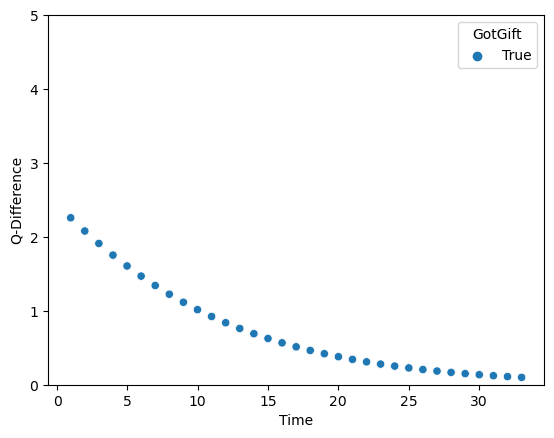

In [6]:
trialTimes = pd.DataFrame(
    {
        "Trial": [],
        "Time": [],
        "Episodes": [],
        "Actions": []
    }
)

data = runTrial()
tim = data["Time"]
episodes = data["Episodes"]
actions = data['ActionCount']
trialTimes.loc[0] = {
    "Trial": 1+1,
    "Time": tim,
    "Episodes": episodes,
    "Actions": actions
}

In [7]:

avgTime = trialTimes["Time"].mean()
avgEpisodes = trialTimes["Episodes"].mean()
avgActions = trialTimes['Actions'].mean()
print("Data:\n\nAverage Time To Converge: "+str(avgTime)+" seconds\nAverage Episodes To Converge: "+str(avgEpisodes)+" episodes\nAverage Actions Taken Before Converging: "+str(avgActions)+"\nTotal Actions: "+str(trialTimes["Actions"].sum()))

Data:

Average Time To Converge: 33.036425828933716 seconds
Average Episodes To Converge: 33.0 episodes
Average Actions Taken Before Converging: 99.0
Total Actions: 99
